In [8]:
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#!pip install --upgrade scipy
#!pip install --upgrade numpy
#!pip install gensim
#!pip install spacy
#!pip install pyLDAvis

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sande\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sande\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sande\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)


### Importing necessary modules

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import re
import string

# Preprocessing libraries
import os
import nltk
import time
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk import ngrams
from wordcloud import WordCloud

# Gensim library
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

# Libraries for visualization
import pyLDAvis
import pyLDAvis.gensim

from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

In [10]:
'''
The below function reads a given .txt file line by line.
If the sentence contains 'Document NYTF ...', it is an indication that the article has ended.
We have made use of the .find() method to check for the occurrence of 'Document NYTF'
All the articles are appended to the top-level list.

The return value looks like:
article_list = [article1, article2, .......... article n]

'''

"\nThe below function reads a given .txt file line by line.\nIf the sentence contains 'Document NYTF ...', it is an indication that the article has ended.\nWe have made use of the .find() method to check for the occurrence of 'Document NYTF'\nAll the articles are appended to the top-level list.\n\nThe return value looks like:\narticle_list = [article1, article2, .......... article n]\n\n"

In [11]:
# Crawls through the directory and reads all the files present inside it.
def article_separator(dir_path):
    articles_list = []
    count = 0
    for root, folders, files in os.walk(dir_path):
        for file in files:
            # print('Reading the file ', file)
            file_path = os.path.join(root, file)
            article = ''
            with open(file_path, 'rb') as f:
                # Reads the file line by line for improved efficiency.
                for sentence in f.readlines():
                    if all(doc not in sentence.decode() for doc in ('Document NYTF', 'Document WSJO', 'Document J')):
                        article += sentence.decode('utf8', 'replace')
                    else:
                        articles_list.append(article)
                        article = ''     
    return articles_list

In [12]:
# Path to the raw text files -- 

articles_list = article_separator('C:/Users/sande/Downloads/Articles/Articles')

In [13]:
print('Total count of articles: ', len(articles_list))

Total count of articles:  1391


In [14]:
print('Sample article view: \n', articles_list[0][:200])

Sample article view: 
  


World; Europe
In Turkey, U.S. Hand Is Seen in Nearly Every Crisis

By TIM ARANGO 
1,447 words
4 January 2017
09:45
NYTimes.com Feed
NYTFEED
English
Copyright 2017. The New York Times Company. All 


In [15]:
import re
import string

def article_cleanser(article):
    # Lowercase text
    article = article.lower()
    # Remove HTML tags
    html_tags = re.compile('<.*?>')
    article = re.sub(html_tags, '', article)
    # Remove text within [] and ()
    article = re.sub('\[.*?\]', '', article)
    article = re.sub('\(.*?\)', '', article)
    # Remove Punctuation marks
    article = re.sub('[%s]' % re.escape(string.punctuation), '', article)
    article = re.sub('\w*\d\w*', '', article)
    # Remove extra characters such as single quotes and double quotes
    article = re.sub('[‘’“”…—]', '', article)
    # Remove escape characters like next line, tab space, etc
    article = re.sub('[\n\t\r\d]', ' ', article)
    
    '''
    Every article consists of metadata that starts from the first line and ends with 'all rights reserved'
    Therefore, we are eliminating all the text that forms the metadata.
    '''   
    # Removing the metadata
    article = re.sub('^(.*?)(all rights reserved)', '', article)
    
    # Removes the left and right spaces of the text.
    article = article.lstrip().rstrip()
    return article

In [16]:
# This will call the article_cleanser function above
def preprocessor(article_list):
    cleaned_articles = []
    for article in articles_list:
        cleaned_article = article_cleanser(article)
        cleaned_articles.append(cleaned_article)
    return cleaned_articles

In [17]:
# Returns the list of all the preprocessed articles

cleaned_articles = preprocessor(articles_list)

In [19]:
# Sample view of the article 1 after cleaning

cleaned_articles[0][:100]

'istanbul urkish officials accused the united states of abetting a failed coup last summer when the r'

In [20]:
# Converts the input text string into tokens
def word_tokenizer(corpus):
    corpus_tokens = word_tokenize(corpus)
    return corpus_tokens

In [21]:
# Writes the stop words to the file 'Stopwords.txt'
def write_to_file(stopwords):
    with open('Stopwords.txt', 'w') as file:
        for word in stopwords:
            file.write(word + '\n')

In [22]:
# Fetches the stop words from 'English' lang in NLTK library
def get_stopwords_english():
    stop_words = set(stopwords.words('english'))
    print('Count of stop words: ', len(stop_words))
    return stop_words

In [23]:
# Fetches the multilingual stop words from NLTK library
def get_stopwords():
    # fileids() returns all the languages present in the NLTK library.
    languages = stopwords.fileids()
    global_stop_words = []
    try:
        temp = []
        for lang in languages:
            lang_stop_words = set(stopwords.words(lang))
            temp.append(lang_stop_words)
    except:
        print('Encontered an error with : ', lang)
    
    for sublist in temp:
        for word in sublist:
            global_stop_words.append(word)
    
#   write_to_file(global_stop_words)
    print('Count of stop words: ', len(global_stop_words))
    return global_stop_words

In [24]:
%%time

'''
Tokenization:

tokens_list: List of lists of articles. (Top level list)
article_tokens: tokens of individual articles.

'''
tokens_list = []
for article in cleaned_articles:
    article_tokens = word_tokenizer(article)
    tokens_list.append(article_tokens)

CPU times: total: 10.9 s
Wall time: 11.2 s


In [25]:
%%time

'''
Stop word removal
'''

# Fetches the stop words from the function
stop_words = get_stopwords()
def remove_stopwords(tokens_list):
    return [[token for token in article_tokens if token not in stop_words] for article_tokens in tokens_list]

Count of stop words:  10204
CPU times: total: 109 ms
Wall time: 417 ms


In [26]:
# Processed tokens after removing all the stop words

all_tokens_without_stop = remove_stopwords(tokens_list)

In [27]:
# Sample list of all the tokens after stop word removal

all_tokens_without_stop[0][:20]

['istanbul',
 'urkish',
 'officials',
 'accused',
 'united',
 'states',
 'abetting',
 'failed',
 'coup',
 'summer',
 'russian',
 'ambassador',
 'turkey',
 'assassinated',
 'month',
 'turkish',
 'press',
 'united',
 'states',
 'attack']

In [28]:
%%time

# Unwind all the tokens into one list for analyzing data.
# unified_tokens: All tokens in one list

unified_tokens = []
for sublist in all_tokens_without_stop:
    for token in sublist:
        unified_tokens.append(token)

CPU times: total: 250 ms
Wall time: 265 ms


In [29]:
print('Length of all the tokens in the corpus: ', len(unified_tokens))

Length of all the tokens in the corpus:  865378


In [30]:
# Returns the list of most frequent words as per the requirement
def freq_Distribution(processed_tokens, top_word_count):
    top_words = FreqDist(processed_tokens).most_common(top_word_count)
    return top_words

In [31]:
# Function to generate the bar graphs or count plot of frequent words

def generate_bar_graph(freq_dict):
    plt.figure(figsize=(6, 4))
    plt.title("Top 30 unigrams in corpus", fontsize=10)
    sns.barplot(y = list(freq_dict.values()), x = list(freq_dict.keys()))
    plt.xlabel('Most Repeating Words')
    plt.xticks(rotation = 90)
    plt.ylabel('Average Frequency')
    plt.grid(visible = False)
    plt.show()

In [32]:
# Function to generate the word cloud for clusters

def generate_word_cloud(freq_dict):
    try:
        wordcloud = WordCloud(min_word_length =3, background_color='white', max_words = 100)
        wordcloud.generate_from_frequencies(freq_dict)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Word Cloud of most common unigrams', size = 10)
        plt.axis('off')
        plt.show()
    except:
        print('An exception occurred while plotting the word cloud.')

In [33]:
def n_grams(unified_tokens, n, words_req):
    if n == 1:
        grams = unified_tokens
    else:
        grams = ngrams(unified_tokens, n)
    print('Top {} {}-grams: \n'.format(words_req, n))
    top_n_grams = FreqDist(grams).most_common(words_req)
    return top_n_grams

In [34]:
# Top 30 unigrams in the corpus

top_30_unigrams = n_grams(unified_tokens, 1, 30)
print(top_30_unigrams)

Top 30 1-grams: 

[('mr', 9788), ('state', 6744), ('trump', 6589), ('islamic', 6157), ('president', 3978), ('syria', 3765), ('states', 3503), ('american', 3461), ('united', 3409), ('military', 3235), ('forces', 2733), ('iraq', 2681), ('government', 2493), ('officials', 2453), ('isis', 2450), ('attack', 2171), ('syrian', 2156), ('group', 2102), ('city', 2097), ('security', 2071), ('years', 1965), ('times', 1931), ('time', 1887), ('country', 1867), ('iraqi', 1860), ('administration', 1759), ('york', 1708), ('news', 1681), ('killed', 1679), ('house', 1589)]


In [35]:
# Convert above list of tuples into frequency dictionary

unigram_dict_30 = dict(top_30_unigrams)

In [36]:
unigram_dict_30

{'mr': 9788,
 'state': 6744,
 'trump': 6589,
 'islamic': 6157,
 'president': 3978,
 'syria': 3765,
 'states': 3503,
 'american': 3461,
 'united': 3409,
 'military': 3235,
 'forces': 2733,
 'iraq': 2681,
 'government': 2493,
 'officials': 2453,
 'isis': 2450,
 'attack': 2171,
 'syrian': 2156,
 'group': 2102,
 'city': 2097,
 'security': 2071,
 'years': 1965,
 'times': 1931,
 'time': 1887,
 'country': 1867,
 'iraqi': 1860,
 'administration': 1759,
 'york': 1708,
 'news': 1681,
 'killed': 1679,
 'house': 1589}

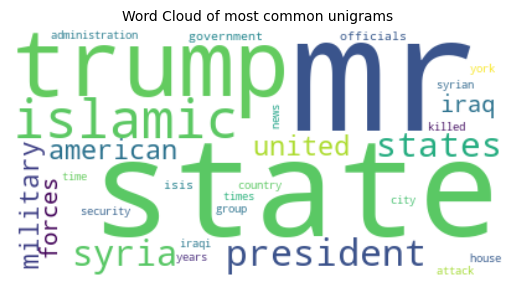

In [37]:
# Word cloud generator for unigrams

generate_word_cloud(unigram_dict_30)

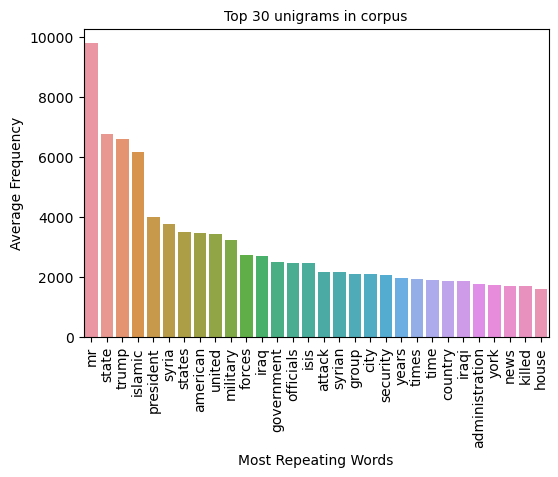

In [38]:
# Bar graph generator for unigrams

generate_bar_graph(unigram_dict_30)

In [39]:
# Top 30 bigrams in the entire corpus

top_30_bi_grams = n_grams(unified_tokens, 2, 30)
print(top_30_bi_grams)

Top 30 2-grams: 

[(('islamic', 'state'), 5276), (('united', 'states'), 2841), (('mr', 'trump'), 2292), (('york', 'times'), 1175), (('white', 'house'), 1007), (('president', 'trump'), 888), (('trump', 'administration'), 633), (('middle', 'east'), 601), (('donald', 'trump'), 569), (('national', 'security'), 496), (('saudi', 'arabia'), 460), (('mr', 'trumps'), 425), (('mr', 'assad'), 419), (('mr', 'obama'), 416), (('prime', 'minister'), 391), (('state', 'fighters'), 382), (('iraq', 'syria'), 382), (('islamic', 'states'), 376), (('obama', 'administration'), 360), (('chemical', 'weapons'), 358), (('dow', 'jones'), 354), (('north', 'korea'), 334), (('iraqi', 'forces'), 328), (('executive', 'order'), 314), (('secretary', 'state'), 305), (('united', 'nations'), 291), (('facebook', 'twitter'), 285), (('social', 'media'), 273), (('barack', 'obama'), 272), (('mr', 'mattis'), 271)]


In [40]:
# Convert above list of tuples into frequency dictionary

bigrams_30_dict = dict(top_30_bi_grams)

In [41]:
print(list(bigrams_30_dict.keys()))

[('islamic', 'state'), ('united', 'states'), ('mr', 'trump'), ('york', 'times'), ('white', 'house'), ('president', 'trump'), ('trump', 'administration'), ('middle', 'east'), ('donald', 'trump'), ('national', 'security'), ('saudi', 'arabia'), ('mr', 'trumps'), ('mr', 'assad'), ('mr', 'obama'), ('prime', 'minister'), ('state', 'fighters'), ('iraq', 'syria'), ('islamic', 'states'), ('obama', 'administration'), ('chemical', 'weapons'), ('dow', 'jones'), ('north', 'korea'), ('iraqi', 'forces'), ('executive', 'order'), ('secretary', 'state'), ('united', 'nations'), ('facebook', 'twitter'), ('social', 'media'), ('barack', 'obama'), ('mr', 'mattis')]


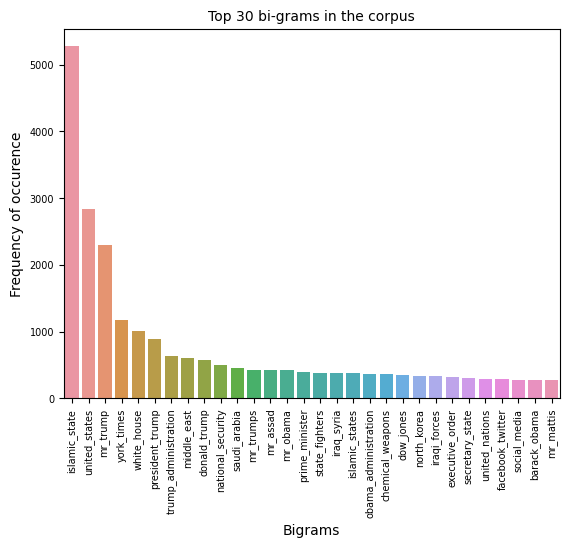

In [42]:
# Bar graph for most frequent bi-grams

# Appending the bigrams into one string

labels = [label[0] + '_' + label[1] for label in list(bigrams_30_dict.keys())]
values = list(bigrams_30_dict.values())

# Creating a dictionary of appended bigrams and frequency
bigram_dict = dict()
for i in range(len(labels)):
    bigram_dict[labels[i]] = values[i]

# Plotting the bigrams
sns.barplot(y = values, x = labels)
plt.title('Top 30 bi-grams in the corpus', fontsize=10)
plt.xlabel('Bigrams', fontsize=10)
plt.ylabel('Frequency of occurence', fontsize=10)
plt.xticks(rotation = 90, fontsize = 7)
plt.yticks(fontsize = 7)
plt.show()

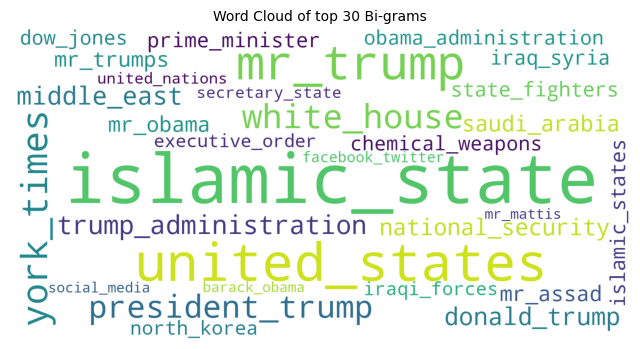

In [43]:
# Generating a word cloud for bigrams using the created bigram dictionary

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate_from_frequencies(bigram_dict)

plt.figure(figsize=(8,8))
plt.title('Word Cloud of top 30 Bi-grams', fontsize=10)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [44]:
# Perform lemmatization on the tokens

'''
Only keeps the words with parts of speech as either of ('Noun', 'Adjective', 'Verb')
'''

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    lemmatized_tokens = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        lemmatized_tokens.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return lemmatized_tokens

In [47]:
#python -m spacy download en_core_web_sm
#import spacy
#spacy.cli.download("en_core_web_sm")



✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [48]:
%%time
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, adv
tokens_lemmatized = lemmatization(all_tokens_without_stop, allowed_postags=['NOUN', 'ADJ'])

CPU times: total: 1min 46s
Wall time: 1min 47s


In [49]:
# Build the bigram and trigram models - higher threshold fewer phrases.
bigram = gensim.models.Phrases(tokens_lemmatized, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[tokens_lemmatized], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [50]:
# Functions to create n_grams

def make_bigrams(tokens_list):
    return [bigram_mod[article_tokens] for article_tokens in tokens_list]

def make_trigrams(tokens_list):
    return [trigram_mod[bigram_mod[article_tokens]] for article_tokens in tokens_list]

In [51]:
token_bigrams = make_bigrams(tokens_lemmatized)

In [52]:
token_bigrams[0]

['urkish',
 'official',
 'coup',
 'summer',
 'russian',
 'ambassador',
 'month',
 'gunman',
 'early',
 'year',
 'day',
 'news',
 'medium',
 'chief',
 'suspectne',
 'headline',
 'attack',
 'twitter',
 'turkish',
 'lawmaker',
 'nightclub',
 'period',
 'turkey',
 'cascade',
 'crisis',
 'syrian',
 'civil',
 'border',
 'event',
 'turkey',
 'close',
 'ally',
 'nation',
 'close',
 'russian',
 'secure',
 'ceasefire',
 'story',
 'routine',
 'travel',
 'warning',
 'american',
 'embassy',
 'responsibility',
 'stun',
 'gunman',
 'stock',
 'american',
 'assault',
 'division',
 'turkey',
 'secular',
 'religious',
 'bringing',
 'common',
 'fight',
 'terrorism',
 'attack',
 'gunman',
 'turkey',
 'shift',
 'west',
 'time',
 'democracy',
 'crackdown',
 'civil',
 'society',
 'reflection',
 'critic',
 'paranoia',
 'authoritarianism',
 'leadership',
 'country',
 'confront',
 'terrorism',
 'turkish',
 'society',
 'administration',
 'day',
 'enemy',
 'islamic',
 'state',
 'kurdish',
 'militant',
 'supporter'

In [53]:
type(token_bigrams)

list

In [54]:
%%time

# Mapping the tokens with those of the dictionary words

id2word = corpora.Dictionary(token_bigrams)

corpus = []
for token_list in token_bigrams:
    new = id2word.doc2bow(token_list)
    corpus.append(new)

CPU times: total: 1.64 s
Wall time: 1.73 s


In [55]:
type(corpus)

list

In [56]:
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 3),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 2),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 2),
 (17, 1),
 (18, 8),
 (19, 1),
 (20, 1),
 (21, 2),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 3),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 2),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 7),
 (50, 4),
 (51, 3),
 (52, 3),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 5),
 (58, 2),
 (59, 1),
 (60, 1),
 (61, 3),
 (62, 1),
 (63, 1),
 (64, 4),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 1),
 (70, 1),
 (71, 2),
 (72, 1),
 (73, 2),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 2),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 4),
 (92, 1),
 (93, 4),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 2),
 (99, 2),
 (100, 1),

### Latent Dirichlet Allocation - Topic Model building

In [57]:
# Building the LDA model
'''
As a trail run, 8 topics are selected.

num_topics: No of topics required.
update_every: Number of documents to be iterated through for each update.
passes: Number of times algorithm passes through the corpus.
alpha: A-priori belief on document-topic distribution.

'''

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics = 8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha="auto")

### Visualizing the topics

In [58]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)

import warnings
warnings.filterwarnings('ignore')

In [59]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.049490  0.346529       1        1  32.592317
2     -0.003570  0.106504       2        1  27.912968
1      0.328221 -0.060642       3        1  13.396229
3     -0.279014  0.158471       4        1  12.799583
4      0.233068  0.221288       5        1   9.101636
0     -0.245134 -0.151659       6        1   2.484641
6     -0.068869 -0.341416       7        1   1.056182
7      0.084789 -0.279074       8        1   0.656443, topic_info=         Term         Freq        Total Category  logprob  loglift
18     attack  2986.000000  2986.000000  Default  30.0000  30.0000
186     state  5700.000000  5700.000000  Default  29.0000  29.0000
49    country  2491.000000  2491.000000  Default  28.0000  28.0000
99    islamic  4481.000000  4481.000000  Default  27.0000  27.0000
415     force  3415.000000  3415.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
938      case    16.430221   767.180639   Topic8  -5.1807   1.1825
1196   lawyer    12.048189   200.203407   Topic8  -5.4909   2.2157
1911  lawsuit     8.896121    44.882644   Topic8  -5.7942   3.4077
979      free     9.470341   248.242871   Topic8  -5.7317   1.7598
430      late     9.423973   625.011170   Topic8  -5.7366   0.8316

[527 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
7681      8  0.933677           abadi
3101      6  0.927576           abide
561       2  0.992954           actor
7087      6  0.931714        adequate
6         1  0.531847  administration
...     ...       ...             ...
5221      6  0.958668          yemeni
1139      2  0.267412           young
1139      3  0.583078           young
1139      5  0.148785           young
3239      5  0.978624         youtube

[915 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 4, 5, 1, 7, 8])

### Analyzing the topics

In [60]:
# Print the Keywords with the repsective weightage in the 10 topics

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

'''
(0,
  '0.034*"state" + 0.029*"islamic" + 0.024*"force" + 0.019*"military" + '
  '0.016*"group" + 0.014*"fighter" + 0.014*"official" + 0.014*"syrian" + '
  '0.014*"government" + 0.013*"iraqi"')

How to read?

In topic 0, the word "state" is the most imp with a weightage of 0.034 
   topic 0, the word "islamic" is the second most imp with a weightage of 0.029 ... 

'''


[(0,
  '0.043*"country" + 0.041*"refugee" + 0.029*"order" + 0.019*"executive_order" '
  '+ 0.017*"immigration" + 0.015*"program" + 0.015*"ban" + 0.014*"security" + '
  '0.013*"trump" + 0.013*"visa"'),
 (1,
  '0.013*"family" + 0.013*"child" + 0.011*"day" + 0.010*"city" + 0.009*"year" '
  '+ 0.008*"home" + 0.007*"woman" + 0.007*"police" + 0.006*"life" + '
  '0.006*"month"'),
 (2,
  '0.011*"year" + 0.009*"world" + 0.009*"time" + 0.006*"story" + '
  '0.006*"country" + 0.005*"political" + 0.005*"week" + 0.004*"isis" + '
  '0.004*"today" + 0.004*"life"'),
 (3,
  '0.026*"trump" + 0.013*"president" + 0.010*"administration" + 0.010*"week" + '
  '0.010*"lot" + 0.009*"company" + 0.008*"big" + 0.008*"policy" + '
  '0.008*"question" + 0.007*"business"'),
 (4,
  '0.048*"attack" + 0.021*"police" + 0.021*"state" + 0.021*"terrorist" + '
  '0.020*"islamic" + 0.018*"group" + 0.017*"official" + 0.011*"authority" + '
  '0.011*"terrorism" + 0.010*"terror"'),
 (5,
  '0.033*"state" + 0.025*"islamic" + 0.024*"

'\n(0,\n  \'0.034*"state" + 0.029*"islamic" + 0.024*"force" + 0.019*"military" + \'\n  \'0.016*"group" + 0.014*"fighter" + 0.014*"official" + 0.014*"syrian" + \'\n  \'0.014*"government" + 0.013*"iraqi"\')\n\nHow to read?\n\nIn topic 0, the word "state" is the most imp with a weightage of 0.034 \n   topic 0, the word "islamic" is the second most imp with a weightage of 0.029 ... \n\n'

### Model Evaluation

In [61]:
'''
Two of the most common metrics used for measuring the topic model's performance
i. Perplexity
ii. Coherence Score
'''



# Compute Perplexity -- a measure of how good the model is. Lower the value better the model.
print('Perplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = token_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', np.round(coherence_lda, 3)) 

Perplexity:  -8.059919870362855
Coherence Score:  0.492


### Choosing the optimal number of topics

In [71]:
%%time
Coherence_scores = []
Perplexity_scores = []

for count in range(5, 15):

    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics = count,
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha="auto")
    # Compute Perplexity
    Perplexity_scores.append(lda_model.log_perplexity(corpus))
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model = lda_model, texts = token_bigrams, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    Coherence_scores.append(coherence_lda)

CPU times: total: 12min 40s
Wall time: 10min 20s


### Plotting the topic count Vs Coherence Score

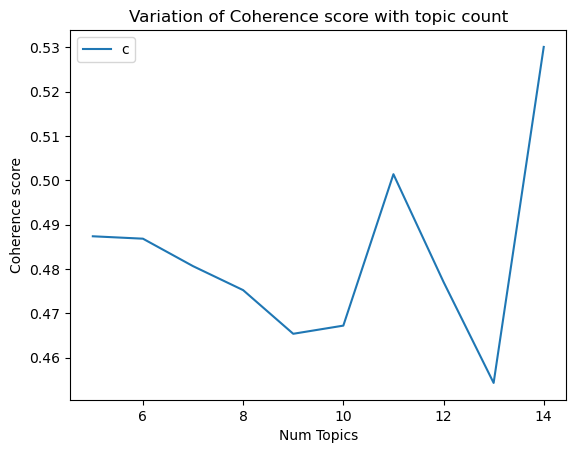

In [72]:
# The number of topics are chosen based on the higest Coherence Score.
# In our case, it is 12.

limit=15; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, Coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Variation of Coherence score with topic count")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [73]:
Coherence_scores

[0.4873863441775965,
 0.48684476582428643,
 0.4806484370954494,
 0.47523632392875576,
 0.46538280065426463,
 0.467224800083912,
 0.5013981548015422,
 0.47708379412445273,
 0.45429473197965875,
 0.5301192856084487]

In [74]:
# Since we are starting from the 5 topics, we have to offset max index with 5.

optimal_no_models = np.argmax(Coherence_scores) + 5

In [75]:
optimal_no_models

14

### Building the model with optimal number of topics

In [76]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= optimal_no_models,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)

import warnings
warnings.filterwarnings('ignore')

### Visualizing the topics and word distributions

In [77]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.056793  0.293201       1        1  26.882849
12    -0.207064  0.291667       2        1  23.362741
5     -0.092654  0.445564       3        1  22.895679
1     -0.374989  0.112915       4        1  14.621309
4      0.217574  0.306461       5        1   4.560709
3      0.358855  0.051308       6        1   2.013782
6     -0.268919 -0.153697       7        1   1.983545
13     0.228614 -0.276183       8        1   1.608682
11     0.189796 -0.058307       9        1   1.199985
7     -0.108418 -0.311738      10        1   0.711318
0      0.003017 -0.215393      11        1   0.129992
10     0.036127 -0.162144      12        1   0.012959
8      0.040737 -0.162610      13        1   0.011961
9      0.034117 -0.161044      14        1   0.004490, topic_info=              Term         Freq        Total Category  logprob  loglift
18          attack  3346.000000  3346.000000  Default  30.0000  30.0000
49         country  2863.000000  2863.000000  Default  29.0000  29.0000
99         islamic  4951.000000  4951.000000  Default  28.0000  28.0000
186          state  6447.000000  6447.000000  Default  27.0000  27.0000
415          force  3706.000000  3706.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
7728   competitive     0.000853     0.867142  Topic14 -10.0615   3.0870
18570        marsh     0.000853     0.864432  Topic14 -10.0616   3.0900
14534  marketplace     0.000853     0.869503  Topic14 -10.0615   3.0843
7146        sector     0.000853     0.872320  Topic14 -10.0615   3.0810
6843       chinese     0.000853     0.880333  Topic14 -10.0615   3.0719

[872 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
910       2  0.942294       abuse
910       4  0.049970       abuse
5635      5  0.935461  accomplice
1365      9  0.950772    activism
1157      1  0.057398    activity
...     ...       ...         ...
1139      2  0.077527       young
1139      4  0.773507       young
1139      5  0.091623       young
1139      7  0.056383       young
3239      6  0.979413     youtube

[1261 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 13, 6, 2, 5, 4, 7, 14, 12, 8, 1, 11, 9, 10])